In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dowhy import CausalModel
import dowhy
import networkx as nx
G = nx.Graph()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [22]:
import dowhy.datasets

In [33]:
data = dowhy.datasets.linear_dataset(beta=10,num_common_causes=5,
                                num_instruments=2, num_samples=1000,
                                    treatment_is_binary=True)

In [34]:
data['gml_graph']

'graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[source "Unobserved Confounders" target "v0"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]]'

In [19]:
df = pd.read_csv('./data/heart.csv')

In [20]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [21]:
df.shape

In [118]:
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
test = df[~mask]

## I copied the graph string and created on my own lets change it to one they do

In [46]:
columns = list(df.columns)
columns.remove(['sex','target'])

In [90]:
graph = "graph[directed 1 "
for node in df.columns:
    graph += f'node[id "{node}" label "{node}"] '
    

In [91]:
graph += 'node[id "Unobserved Confounders" label "Unobserved Confounders"] '

In [93]:
for col in columns:
    graph += f'edge[source "{col}" target "target"] '

In [94]:
graph += f'edge[source "Unobserved Confounders" target "target"] '
graph += f'edge[source "Unobserved Confounders" target "sex"] '


In [95]:
graphn = graph[:-1] + ']'

In [96]:
graphn

'graph[directed 1 node[id "age" label "age"] node[id "sex" label "sex"] node[id "cp" label "cp"] node[id "trestbps" label "trestbps"] node[id "chol" label "chol"] node[id "fbs" label "fbs"] node[id "restecg" label "restecg"] node[id "thalach" label "thalach"] node[id "exang" label "exang"] node[id "oldpeak" label "oldpeak"] node[id "slope" label "slope"] node[id "ca" label "ca"] node[id "thal" label "thal"] node[id "target" label "target"] node[id "Unobserved Confounders" label "Unobserved Confounders"] edge[source "age" target "target"] edge[source "sex" target "target"] edge[source "cp" target "target"] edge[source "trestbps" target "target"] edge[source "chol" target "target"] edge[source "fbs" target "target"] edge[source "restecg" target "target"] edge[source "thalach" target "target"] edge[source "exang" target "target"] edge[source "oldpeak" target "target"] edge[source "slope" target "target"] edge[source "ca" target "target"] edge[source "thal" target "target"] edge[source "Un

In [102]:
# this is the graph string format that they used in
graph="""graph[directed 1 node[id "Z" label "Z"]
                    node[id "X" label "X"]
                    node[id "Y" label "Y"]
                    edge[source "Z" target "X"]
                    edge[source "Z" target "Y"]
                    edge[source "X" target "Y"]]"""

In [120]:
model = CausalModel(data=train,
                   treatment=['sex'],
                   outcome=['target'],
                    graph=graphn
                   )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['sex'] on outcome ['target']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


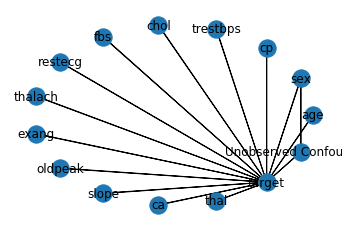

In [121]:
model.view_model()

In [122]:
# I clicked on no bu I put the unobserved confounders to the nodes in graph dont know why
identified_estimand = model.identify_effect()

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Unobserved Confounders']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [123]:
estimate = model.estimate_effect(identified_estimand, method_name='backdoor.linear_regression',
                                test_significance=True)
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: target~sex+sex*thal+sex*cp+sex*thalach+sex*chol+sex*age+sex*fbs+sex*exang+sex*restecg+sex*ca+sex*oldpeak+sex*trestbps+sex*slope


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
──────(Expectation(target))
d[sex]                     
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→target then P(target|sex,,U) = P(target|sex,)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: target~sex+sex*thal+sex*cp+sex*thalach+sex*chol+sex*age+sex*fbs+sex*exang+sex*restecg+sex*ca+sex*oldpeak+sex*trestbps+sex*slope
## Estimate
Value: -0.10860570020191451

## Statistical Significance
p-value: 0.436



In [124]:
print("Causal Estimate is " + str(estimate.value))
data_1 = df[df["exang"]==1]
data_0 = df[df["exang"]==0]

print("ATE", np.mean(data_1["target"])- np.mean(data_0["target"]))

Causal Estimate is -0.10860570020191451
ATE -0.46375519904931667
